In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
# Read data
listing=pd.read_csv("listing_us.csv")

/var/folders/wq/lz1mv8gj227bv83rhxpf97rh0000gn/T/ipykernel_8035/1542708656.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  listing=pd.read_csv("listing_us.csv")


## EDA

In [72]:
# Data Size check 
print(f"Los Angeles size: {len(listing_la)}, New York size: {len(listing_ny)}")

Los Angeles size: 42451, New York size: 42931


In [73]:
listing.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'city'],
      dtype='object')

In [74]:
listing.isnull().sum()

id                                     0
name                                  16
host_id                                0
host_name                             13
neighbourhood_group               135647
neighbourhood                          0
latitude                               0
longitude                              0
room_type                              0
price                                  0
minimum_nights                         0
number_of_reviews                      0
last_review                        49085
reviews_per_month                  49085
calculated_host_listings_count         0
availability_365                       0
number_of_reviews_ltm                  0
city                                   0
dtype: int64

Drop ["host_id", "host_name", "neighbourhood_group", "neighbourhood", "latitude", "longitude"]

In [75]:
listing.drop(["host_id", "host_name", "neighbourhood_group", "neighbourhood", "latitude", "longitude"], axis=1, inplace=True)

In [76]:
from scipy import stats

In [77]:
# Remove Outlier
z_price = np.abs(stats.zscore(listing["price"]))
print(f"Percentage of data without outlier {round((len(listing[z_price<3])/len(listing)),4)*100}%")
listing = listing[z_price<3]

Percentage of data without outlier 99.63%


In [78]:
# EDA for last_review
from datetime import datetime
listing["last_review"] = pd.to_datetime(listing["last_review"])
listing["days_from_last_review_23"] = (datetime.strptime("2023-12-31", "%Y-%m-%d") - listing["last_review"]).dt.days
listing["days_from_last_review_23"].fillna(-1, inplace=True)
listing["days_from_last_review_23"]=listing["days_from_last_review_23"].astype(int)

/var/folders/wq/lz1mv8gj227bv83rhxpf97rh0000gn/T/ipykernel_8035/1869866303.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  listing["days_from_last_review_23"].fillna(-1, inplace=True)


In [79]:
-listing[((listing["city"]=="Los Angeles")|(listing["city"]=="New York City"))&(listing["days_from_last_review_23"]==-1)]["days_from_last_review_23"].sum()/len(listing)

np.float64(0.09388228070858141)

In [80]:
# Make rating cuz no. of reviews are scattered  
listing["reviews_rate"] = listing["number_of_reviews_ltm"]/listing["number_of_reviews"]

In [81]:
# Binning 'availability_365' into 4 bins
listing['availability'] = pd.cut(listing['availability_365'], bins=[0, 90, 180, 270, 365], labels=['low', 'medium', 'high', 'very high'])

In [82]:
# Price itself itn't a good feature, 
listing['price_per_night'] = listing['price'] / listing['minimum_nights']

In [83]:
listing.drop(["id", "name"], axis=1, inplace=True)

In [84]:
from sklearn.preprocessing import StandardScaler

numeric_columns = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
                   'calculated_host_listings_count', "availability_365",
                   'number_of_reviews_ltm', 'days_from_last_review_23', 'reviews_rate']

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the standardization to the selected numeric columns
listing[numeric_columns] = scaler.fit_transform(listing[numeric_columns])

<Axes: >

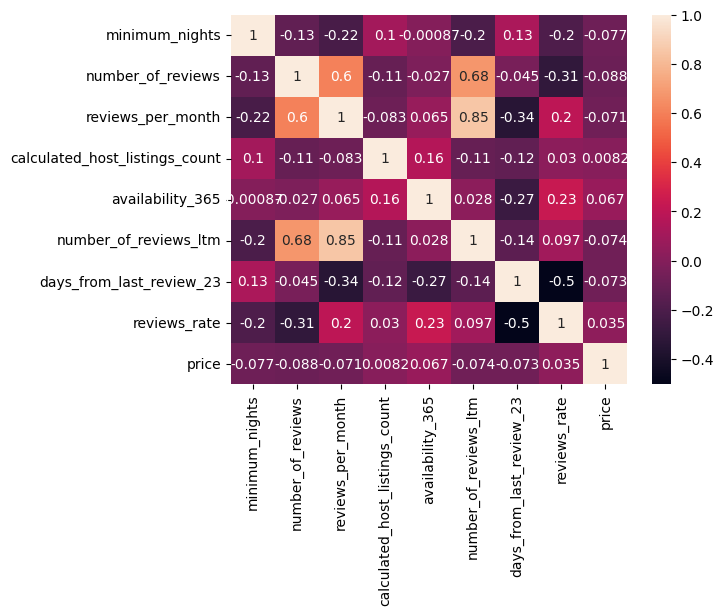

In [85]:
numeric_columns.append("price")
sns.heatmap(listing[numeric_columns].corr(), annot=True)

In [112]:
#Create Category outcome by price threshold. I feel 50 bucks per night is good threshold. Over 50, i feel expensive.
def categorize_price(price):
    if price < 50:
        return 'low'
    else:
        return 'high'

In [113]:
listing['price_category_per_night'] = listing['price_per_night'].apply(categorize_price)

In [114]:
listing["price_category_per_night"].value_counts()/len(listing)

price_category_per_night
high    0.519688
low     0.480312
Name: count, dtype: float64

In [116]:
# create dummy variables for room type
dummies = pd.get_dummies(listing["room_type"], prefix="roomtype")
listing = pd.concat([listing.drop(columns=["room_type"]), dummies], axis=1)


In [151]:
listing["price_category_per_night"].replace({"high":1, "low":0}, inplace=True)

/var/folders/wq/lz1mv8gj227bv83rhxpf97rh0000gn/T/ipykernel_8035/3789109718.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  listing["price_category_per_night"].replace({"high":1, "low":0}, inplace=True)


## Model

In [ ]:
"""
X; roomtype_Entire home/apt, roomtype_Hotel room, roomtype_Private room, number_of_reviews_ltm, availability_365, days_from_last_review_23, (calculated_host_listings_count)
y; price_category_per_night
"""

In [153]:
# Filter for city
listing_la = listing[listing["city"]=="Los Angeles"]
listing_ny = listing[listing["city"]=="New York City"]

In [154]:
x_columns = ["roomtype_Entire home/apt", "roomtype_Hotel room", "roomtype_Private room", "number_of_reviews_ltm", "availability_365", "days_from_last_review_23", "calculated_host_listings_count"]

In [155]:
X_la = listing_la[x_columns].astype(int)
y_la = listing_la["price_category_per_night"]
X_ny = listing_ny[x_columns].astype(int)
y_ny = listing_ny["price_category_per_night"]

In [156]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [157]:
# Split data
X_la_train, X_la_test, y_la_train, y_la_test = train_test_split(X_la, y_la, test_size=0.3, random_state=42)
X_ny_train, X_ny_test, y_ny_train, y_ny_test = train_test_split(X_ny, y_ny, test_size=0.3, random_state=42)

### Logistic Regression

In [158]:
from sklearn.linear_model import LogisticRegression

In [159]:
lr_la = LogisticRegression()
lr_la.fit(X_la_train, y_la_train)
lr_ny = LogisticRegression()
lr_ny.fit(X_ny_train, y_ny_train)

LogisticRegression()

In [160]:
y_pred_la = lr_la.predict(X_la_test)
y_pred_ny = lr_ny.predict(X_ny_test)

In [161]:
# model validation
accuracy_la = accuracy_score(y_la_test, y_pred_la)
conf_matrix_la = confusion_matrix(y_la_test, y_pred_la)
report_la = classification_report(y_la_test, y_pred_la)

print("Accuracy, Los Angeles:", accuracy_la)
print("\nConfusion Matrix, Los Angeles:\n", conf_matrix_la)
print("\nClassification Report, Los Angeles:\n", report_la)

Accuracy, Los Angeles: 0.6820877817319099

Confusion Matrix, Los Angeles:
 [[7640  218]
 [3802  985]]

Classification Report, Los Angeles:
               precision    recall  f1-score   support

           0       0.67      0.97      0.79      7858
           1       0.82      0.21      0.33      4787

    accuracy                           0.68     12645
   macro avg       0.74      0.59      0.56     12645
weighted avg       0.72      0.68      0.62     12645



#### Summary of Logistic Regression result, LA
- Label "low", 0, price < $50 by each night
 Precision: 0.67, the ratio of correctly predicted instances of "low" out of all instances predicted "low". 67% of the prediction of "low" were correct in all prediction. Soso nice
 Recall: 0.97, the ratio of correctly predicted instances of "low" out of all instances actual "low" 97% of the prediction of "low" were correct in all actual. Absolutely nice.
 F1 score: 0.79, Overall evaluation with consideration of precision and recall. aroun 80% is pretty good.

- Label "high", 0, price >= $50 by each night
 Precision: 0.82, the ratio of correctly predicted instances of "high" out of all instances predicted "high". 82% of the prediction of "low" were correct in all prediction. Pretty good
 Recall: 0.21, the ratio of correctly predicted instances of "high" out of all instances actual "high". 21% of the prediction of "low" were correct in all actual. So bad, assume this affect the overall accuracy.
 F1 score: 0.33, Overall evaluation with consideration of precision and recall. 33% is pretty bad.

=> Prediction for label 1 is low....

In [227]:
# obtain coefficients
coefficients_la = lr_la.coef_[0]  # yが2クラスの場合
feature_names_la = X_la_train.columns

# Aggregate coefficients into a dataframe
coeff_df_la = pd.DataFrame({
    'Feature': feature_names_la,
    'Coefficient': coefficients_la
})

# sort by importances
coeff_df_la = coeff_df_la.sort_values(by='Coefficient', ascending=False)
print(coeff_df_la)

                          Feature  Coefficient
1             roomtype_Hotel room     2.865669
0        roomtype_Entire home/apt     2.041150
2           roomtype_Private room     1.524629
3           number_of_reviews_ltm     1.189014
4                availability_365     0.092600
5        days_from_last_review_23    -0.558482
6  calculated_host_listings_count    -3.190102


In [228]:
# Intercept
print(lr_la.intercept_[0])

-2.3257694498823045


In [180]:
# model validation
accuracy_ny = accuracy_score(y_ny_test, y_pred_ny)
conf_matrix_ny = confusion_matrix(y_ny_test, y_pred_ny)
report_ny = classification_report(y_ny_test, y_pred_ny)

print("Accuracy, Los Angeles:", accuracy_ny)
print("\nConfusion Matrix, Los Angeles:\n", conf_matrix_ny)
print("\nClassification Report, Los Angeles:\n", report_ny)

Accuracy, Los Angeles: 0.7055071561916615

Confusion Matrix, Los Angeles:
 [[7716  806]
 [2980 1354]]

Classification Report, Los Angeles:
               precision    recall  f1-score   support

           0       0.72      0.91      0.80      8522
           1       0.63      0.31      0.42      4334

    accuracy                           0.71     12856
   macro avg       0.67      0.61      0.61     12856
weighted avg       0.69      0.71      0.67     12856



#### Summary of Logistic Regression result, NY
- Label "low", 0, price < $50 by each night
 Precision: 0.72, the ratio of correctly predicted instances of "low" out of all instances predicted "low". 72% of the prediction of "low" were correct in all prediction. Soso nice
 Recall: 0.91, the ratio of correctly predicted instances of "low" out of all instances actual "low" 91% of the prediction of "low" were correct in all actual. Absolutely nice.
 F1 score: 0.80, Overall evaluation with consideration of precision and recall. aroun 0.80 is pretty good.

- Label "high", 0, price >= $50 by each night
 Precision: 0.63, the ratio of correctly predicted instances of "high" out of all instances predicted "high". 63% of the prediction of "low" were correct in all prediction. Pretty good
 Recall: 0.31, the ratio of correctly predicted instances of "high" out of all instances actual "high". 31% of the prediction of "low" were correct in all actual. So bad, assume this affect the overall accuracy.
 F1 score: 0.42, Overall evaluation with consideration of precision and recall. 0,42 is pretty bad.

=> Prediction for label 1 is low as well.... Seems model for New York is more balanced compared to LA.

In [229]:
# obtain coefficients
coefficients_ny = lr_ny.coef_[0]  # yが2クラスの場合
feature_names_ny = X_ny_train.columns

# Aggregate coefficients into a dataframe
coeff_df_ny = pd.DataFrame({
    'Feature': feature_names_ny,
    'Coefficient': coefficients_ny
})

# sort by importances
coeff_df_ny = coeff_df_ny.sort_values(by='Coefficient', ascending=False)
print(coeff_df_ny)

                          Feature  Coefficient
1             roomtype_Hotel room     2.250938
3           number_of_reviews_ltm     1.108923
0        roomtype_Entire home/apt     0.978211
2           roomtype_Private room     0.542735
4                availability_365     0.318321
6  calculated_host_listings_count    -0.308036
5        days_from_last_review_23    -0.893895


In [230]:
# Intercept
print(lr_ny.intercept_[0])

-1.258591457142967


## GridSearch for Logistic Regression

In [173]:
from sklearn.model_selection import GridSearchCV

In [174]:
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "max_iter": [100, 200, 300, 400, 500]
}

In [176]:
# Grid search with cross validation
grid_search_la = GridSearchCV(LogisticRegression(), param_grid, cv=10, n_jobs=-1)
grid_search_la.fit(X_la_train, y_la_train)

# Show the best parameter and score
print("Best Parameters for Logistic Regression (LA):", grid_search_la.best_params_)
print("Best Score for Logistic Regression (LA):", grid_search_la.best_score_)

# predict with the best model
y_pred_la_grid = grid_search_la.best_estimator_.predict(X_la_test)

Best Parameters for Logistic Regression (LA): {'C': 10, 'max_iter': 100}
Best Score for Logistic Regression (LA): 0.6785416032485398


In [177]:
# model validation
accuracy_la_grid = accuracy_score(y_la_test, y_pred_la_grid)
conf_matrix_la_grid = confusion_matrix(y_la_test, y_pred_la_grid)
report_la_grid = classification_report(y_la_test, y_pred_la_grid)

print("Accuracy, Los Angeles:", accuracy_la_grid)
print("\nConfusion Matrix, Los Angeles:\n", conf_matrix_la_grid)
print("\nClassification Report, Los Angeles:\n", report_la_grid)

Accuracy, Los Angeles: 0.6820877817319099

Confusion Matrix, Los Angeles:
 [[7639  219]
 [3801  986]]

Classification Report, Los Angeles:
               precision    recall  f1-score   support

           0       0.67      0.97      0.79      7858
           1       0.82      0.21      0.33      4787

    accuracy                           0.68     12645
   macro avg       0.74      0.59      0.56     12645
weighted avg       0.72      0.68      0.62     12645



In [181]:
# Grid search with cross validation
grid_search_ny = GridSearchCV(LogisticRegression(), param_grid, cv=10, n_jobs=-1)
grid_search_ny.fit(X_ny_train, y_ny_train)

# Show the best parameter and score
print("Best Parameters for Logistic Regression (NY):", grid_search_ny.best_params_)
print("Best Score for Logistic Regression (NY):", grid_search_ny.best_score_)

# predict with the best model
y_pred_ny_grid = grid_search_ny.best_estimator_.predict(X_ny_test)

Best Parameters for Logistic Regression (NY): {'C': 10, 'max_iter': 100}
Best Score for Logistic Regression (NY): 0.6980497165721908


In [182]:
# model validation
accuracy_ny_grid = accuracy_score(y_ny_test, y_pred_ny_grid)
conf_matrix_ny_grid = confusion_matrix(y_ny_test, y_pred_ny_grid)
report_ny_grid = classification_report(y_ny_test, y_pred_ny_grid)

print("Accuracy, New York:", accuracy_ny_grid)
print("\nConfusion Matrix, New York:\n", conf_matrix_ny_grid)
print("\nClassification Report, New York:\n", report_ny_grid)

Accuracy, New York: 0.7055071561916615

Confusion Matrix, New York:
 [[7716  806]
 [2980 1354]]

Classification Report, New York:
               precision    recall  f1-score   support

           0       0.72      0.91      0.80      8522
           1       0.63      0.31      0.42      4334

    accuracy                           0.71     12856
   macro avg       0.67      0.61      0.61     12856
weighted avg       0.69      0.71      0.67     12856



No difference, let's search another model, and redo feature engineering

## Decision Tree

In [179]:
from sklearn.tree import DecisionTreeClassifier

In [185]:
dt = DecisionTreeClassifier(criterion="entropy", random_state=42)
dt_la = dt.fit(X_la_train, y_la_train)
y_pred_dt_la = dt_la.predict(X_la_test)
dt_ny = dt.fit(X_ny_train, y_ny_train)
y_pred_dt_ny = dt_ny.predict(X_ny_test)

In [187]:
# model validation
accuracy_la_dt = accuracy_score(y_la_test, y_pred_dt_la)
conf_matrix_la_dt = confusion_matrix(y_la_test, y_pred_dt_la)
report_la_dt = classification_report(y_la_test, y_pred_dt_la)

print("Accuracy, Los Angeles:", accuracy_la_dt)
print("\nConfusion Matrix, Los Angeles:\n", conf_matrix_la_dt)
print("\nClassification Report, Los Angeles:\n", report_la_dt)

Accuracy, Los Angeles: 0.6821668643732701

Confusion Matrix, Los Angeles:
 [[7652  206]
 [3813  974]]

Classification Report, Los Angeles:
               precision    recall  f1-score   support

           0       0.67      0.97      0.79      7858
           1       0.83      0.20      0.33      4787

    accuracy                           0.68     12645
   macro avg       0.75      0.59      0.56     12645
weighted avg       0.73      0.68      0.62     12645



In [189]:
# model validation
accuracy_ny_dt = accuracy_score(y_ny_test, y_pred_dt_ny)
conf_matrix_ny_dt = confusion_matrix(y_ny_test, y_pred_dt_ny)
report_ny_dt = classification_report(y_ny_test, y_pred_dt_ny)

print("Accuracy, New York:", accuracy_ny_dt)
print("\nConfusion Matrix, New York:\n", conf_matrix_ny_dt)
print("\nClassification Report, New York:\n", report_ny_dt)

Accuracy, New York: 0.7140634723086496

Confusion Matrix, New York:
 [[8333  189]
 [3487  847]]

Classification Report, New York:
               precision    recall  f1-score   support

           0       0.70      0.98      0.82      8522
           1       0.82      0.20      0.32      4334

    accuracy                           0.71     12856
   macro avg       0.76      0.59      0.57     12856
weighted avg       0.74      0.71      0.65     12856



No huge difference between Logistic Regression and Decision Tree, meaning that model does not matter, featuer engineering. we wanna know which attributes is affecting most. For New York, Decision Tree is bit better than Logistic Regression.

## Grid Search for Decision Tree

In [191]:
# parameters
param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

In [193]:
# Optimization of parameters
grid_search_la_dt = GridSearchCV(DecisionTreeClassifier(criterion = "entropy",random_state=42), param_grid_dt, cv=10, n_jobs=-1)
grid_search_la_dt.fit(X_la_train, y_la_train)

# Display best parameters
print("Best parameters found by GridSearchCV:", grid_search_la_dt.best_params_)

# Predict with best model
y_pred_dt_optimized_la = grid_search_la_dt.best_estimator_.predict(X_la_test)

# 精度評価
accuracy_optimized_la_dt = accuracy_score(y_la_test, y_pred_dt_optimized_la)
print(f"Optimized Decision Tree Accuracy: {accuracy_optimized_la_dt:.4f}")
print(f"Original Model Accuracy: {accuracy_la_dt:.4f}")

Best parameters found by GridSearchCV: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}
Optimized Decision Tree Accuracy: 0.6822
Original Model Accuracy: 0.6822


In [196]:
# Optimization of parameters
grid_search_ny_dt = GridSearchCV(DecisionTreeClassifier(criterion = "entropy",random_state=42), param_grid_dt, cv=10, n_jobs=-1)
grid_search_ny_dt.fit(X_ny_train, y_ny_train)

# Display best parameters
print("Best parameters found by GridSearchCV:", grid_search_ny_dt.best_params_)

# Predict with best model
y_pred_dt_optimized_ny= grid_search_la_dt.best_estimator_.predict(X_ny_test)

# 精度評価
accuracy_optimized_ny_dt = accuracy_score(y_ny_test, y_pred_dt_optimized_ny)
print(f"Optimized Decision Tree Accuracy: {accuracy_optimized_ny_dt:.4f}")
print(f"Original Model Accuracy: {accuracy_ny_dt:.4f}")

Best parameters found by GridSearchCV: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}
Optimized Decision Tree Accuracy: 0.7076
Original Model Accuracy: 0.7141


=> For Los Angeles, Overfitting????

## Ensemble Learning, RandomForest

In [197]:
from sklearn.ensemble import RandomForestClassifier

In [198]:
# Random Forest Model
rf = RandomForestClassifier(criterion="entropy", n_estimators=100, random_state=42)

# training
rf_la=rf.fit(X_la_train, y_la_train)

# Prediction
y_pred_rf_la = rf_la.predict(X_la_test)

# accuracy check
accuracy_rf_la = accuracy_score(y_la_test, y_pred_rf_la)
print(f"Accuracy of Random Forest model: {accuracy_rf_la:.4f}")
print(f"Original Model Accuracy: {accuracy_la_dt:.4f}")

Accuracy of Random Forest model: 0.6822
Original Model Accuracy: 0.6822


In [225]:
feature_importances_la = rf_la.feature_importances_

# Aggegate Feature & Importances into data frame
importance_df_la = pd.DataFrame({
    'Feature': X_la_train.columns,
    'Importance': feature_importances_la
})

# Sort by imortances
importance_df_la = importance_df_la.sort_values(by='Importance', ascending=False)
print(importance_df_la)

                          Feature  Importance
3           number_of_reviews_ltm    0.355932
6  calculated_host_listings_count    0.280510
5        days_from_last_review_23    0.186786
0        roomtype_Entire home/apt    0.078407
2           roomtype_Private room    0.046970
4                availability_365    0.036909
1             roomtype_Hotel room    0.014486


In [200]:
# Random Forest Model
rf = RandomForestClassifier(criterion="entropy", n_estimators=100, random_state=42)

# 学習
rf_ny=rf.fit(X_ny_train, y_ny_train)

# 予測
y_pred_rf_ny = rf_ny.predict(X_ny_test)

# 精度評価
accuracy_rf_ny = accuracy_score(y_ny_test, y_pred_rf_ny)
print(f"Accuracy of Random Forest model: {accuracy_rf_ny:.4f}")
print(f"Original Model Accuracy: {accuracy_ny_dt:.4f}")

Accuracy of Random Forest model: 0.7142
Original Model Accuracy: 0.7141


In [226]:
feature_importances_ny = rf_ny.feature_importances_

# Aggegate Feature & Importances into data frame
importance_df_ny = pd.DataFrame({
    'Feature': X_ny_train.columns,
    'Importance': feature_importances_ny
})

# Sort by imortances
importance_df_ny = importance_df_ny.sort_values(by='Importance', ascending=False)
print(importance_df_ny)

                          Feature  Importance
5        days_from_last_review_23    0.395608
3           number_of_reviews_ltm    0.207535
6  calculated_host_listings_count    0.169007
4                availability_365    0.148286
0        roomtype_Entire home/apt    0.035814
2           roomtype_Private room    0.024329
1             roomtype_Hotel room    0.019421


## Feature Selection

In [217]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [220]:
X_la_train.shape

(29503, 7)

In [221]:
sfs_model_la=sfs(RandomForestClassifier(criterion="entropy"),k_features = 7,
                forward=True,
                verbose=2,
                cv=5,
                n_jobs=-1,
                scoring='r2')
sfs_model_la.fit(X_la_train, y_la_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    5.3s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    5.4s finished

[2024-11-24 21:05:56] Features: 1/7 -- score: -0.36869368718869566[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.3s finished

[2024-11-24 21:05:58] Features: 2/7 -- score: -0.3659592162179107[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished

[2024-11-24 21:06:00] Features: 3/7 -- score: -0.36451997069241154[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  

SequentialFeatureSelector(estimator=RandomForestClassifier(criterion='entropy'),
                          k_features=(7, 7), n_jobs=-1, scoring='r2',
                          verbose=2)

In [222]:
print('Best accuracy score: %.2f' % sfs_model_la.k_score_)   # k_score_ shows the best score 
print('Best subset (indices):', sfs_model_la.k_feature_idx_) # k_feature_idx_ shows the index of features that yield the best score

Best accuracy score: -0.36
Best subset (indices): (0, 1, 2, 3, 4, 5, 6)


In [223]:
print('Best subset (corresponding names):')
sfs_model_la.k_feature_names_

Best subset (corresponding names):


('roomtype_Entire home/apt',
 'roomtype_Hotel room',
 'roomtype_Private room',
 'number_of_reviews_ltm',
 'availability_365',
 'days_from_last_review_23',
 'calculated_host_listings_count')

In [224]:
listing

,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,city,days_from_last_review_23,reviews_rate,availability,price_per_night,price_category_per_night,roomtype_Entire home/apt,roomtype_Hotel room,roomtype_Private room,roomtype_Shared room
0,202,-0.412692,4.235850,2023-02-19,0.350467,-0.271630,-0.392730,2.291858,San Francisco,-0.257208,-0.839753,medium,101.000000,1,True,False,False,False
1,235,0.592791,0.866732,2017-08-06,-0.512707,-0.271630,1.367066,-0.568612,San Francisco,3.452959,-1.216944,very high,7.833333,0,True,False,False,False
2,56,0.664612,-0.396688,2022-10-27,-0.810894,-0.158442,1.367066,-0.520129,San Francisco,-0.046298,-0.944883,very high,1.750000,0,False,False,True,False
3,575,-0.161321,-0.161345,2019-06-28,-0.769043,-0.262198,1.367066,-0.568612,San Francisco,2.185670,-1.216944,very high,63.888889,1,True,False,False,False
4,110,-0.448602,9.029413,2023-02-25,1.574604,-0.262198,-0.162546,1.079795,San Francisco,-0.268212,-1.108826,medium,110.000000,1,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232142,389,-0.412692,-0.508166,NaT,NaN,-0.271630,1.367066,-0.568612,San Mateo County,-0.836749,NaN,very high,194.500000,1,True,False,False,False
232143,158,-0.448602,-0.508166,NaT,NaN,-0.271630,1.359641,-0.568612,San Mateo County,-0.836749,NaN,very high,158.000000,1,True,False,False,False
232144,97,-0.448602,-0.508166,NaT,NaN,0.020773,1.322514,-0.568612,San Mateo County,-0.836749,NaN,very high,97.000000,1,True,False,False,False
232145,62,-0.412692,-0.508166,NaT,NaN,-0.252765,-0.845673,-0.568612,San Mateo County,-0.836749,NaN,low,31.000000,0,False,False,True,False


### Neural Network (Optional)

In [162]:
import tensorflow as tf

In [168]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_la_train.shape[1],)),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer = tf.keras.regularizers.l1(0.01))
])

In [169]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
# train model
history = model.fit(X_la_train, y_la_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# モデルによる予測
y_pred_la_nn = (model.predict(X_la_test) > 0.5).astype("int32")

# モデル性能の評価
accuracy = accuracy_score(y_la_test, y_pred_la_nn)
print("Accuracy:", accuracy)

Epoch 1/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - accuracy: 0.5586 - loss: 0.7541 - val_accuracy: 0.6882 - val_loss: 0.6362
Epoch 2/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - accuracy: 0.6724 - loss: 0.6347 - val_accuracy: 0.6882 - val_loss: 0.6136
Epoch 3/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step - accuracy: 0.6745 - loss: 0.6088 - val_accuracy: 0.6882 - val_loss: 0.5888
Epoch 4/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - accuracy: 0.6779 - loss: 0.5932 - val_accuracy: 0.6882 - val_loss: 0.5861
Epoch 5/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - accuracy: 0.6751 - loss: 0.5932 - val_accuracy: 0.6882 - val_loss: 0.5846
Epoch 6/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - accuracy: 0.6693 - loss: 0.5948 - val_accuracy: 0.6882 - val_loss: 0.5833
Epoch 7/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step - accuracy: 0.6772 - loss: 0.5891 - val_accuracy: 0.6885 - val_loss: 0.5827
Epoch 8/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - accuracy: 0.6754 - loss: 0.5893 - 

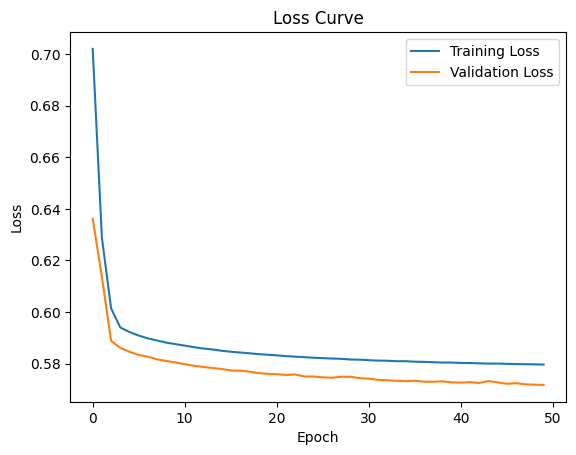

In [170]:
# Visualize the cost function 
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [171]:
y_pred_nn_la = (model.predict(X_la_test) > 0.5).astype(int)
accuracy_nn_la = accuracy_score(y_la_test, y_pred_nn_la)
print("NN Accuracy:", accuracy_nn_la)

396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
NN Accuracy: 0.6819296164491894


c